# Import libraries

In [ ]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style to 'darkgrid'
sns.set_style('darkgrid')
# Execute the matplotlib magic function to ensure plots are displayed inline
%matplotlib inline

# Pull all data into df

In [ ]:
soda = "https://data.cityofnewyork.us/resource/43nn-pn8j.json"

limit = 50000 # max limit of soda api
offset = 0

all_data = []

while True:
    parameters = {
        "$limit": limit,
        "$offset": offset,
    }

    response = requests.get(soda, params=parameters)

    if response.status_code == 200:
        data = response.json()
        if not data:
            break
        # append data from this iteration and increase offset
        all_data.extend(data)
        offset += limit
    else:
        print("Error:", response.status_code, response.text)
        break

df = pd.DataFrame(all_data)
display(df)

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,...,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,grade,grade_date
0,50060214,EL NUEVO VALLE III,Bronx,268,EAST 167 STREET,10456,9178010086,Latin American,2022-01-03T00:00:00.000,Violations were cited in the following area(s).,...,40.833319665533,-73.914214042352,204,16,018101,2002601,2024490060,BX14,NaN,NaN
1,50116809,K-Noodle,Queens,3504,154TH ST,11354,9176604184,Korean,2022-07-05T00:00:00.000,Violations were cited in the following area(s).,...,40.765823243954,-73.810851960991,407,20,115500,4119160,4052640018,QN51,NaN,NaN
2,41706342,ROCKAWAY CAFE,Queens,0,JFK BUILDING 250,11430,7182900840,American,2020-02-11T00:00:00.000,Violations were cited in the following area(s).,...,40.653054721833,-73.767875394333,483,28,071600,4542328,4142600001,QN98,B,2020-02-11T00:00:00.000
3,50116399,SERAFINA IN THE SKY,Manhattan,400,WEST 42 STREET,10036,9176912081,NaN,1900-01-01T00:00:00.000,NaN,...,40.758496674482,-73.992834867711,104,03,011500,1089690,1010517503,MN15,NaN,NaN
4,50144630,WINGSTOP,Manhattan,3440,BROADWAY,10031,6314847232,NaN,1900-01-01T00:00:00.000,NaN,...,40.823224733418,-73.952432705059,109,07,022500,1061758,1020720001,MN04,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210866,50053197,KOTOBUKI,Manhattan,56,3 AVENUE,10003,2123535088,Japanese,2023-03-13T00:00:00.000,Violations were cited in the following area(s).,...,40.731021287218,-73.988843617579,103,02,004200,1008973,1005560024,MN22,N,NaN
210867,50038206,PICKLER & CO,Manhattan,216,EAST 45 STREET,10017,4129521977,American,2019-12-11T00:00:00.000,Violations were cited in the following area(s).,...,40.752427673935,-73.972457367894,106,04,009000,1037579,1013180038,MN19,A,2019-12-11T00:00:00.000
210868,50124689,KA WAH,Bronx,3044,VALENTINE AVENUE,10458,7183642458,Chinese,2023-02-08T00:00:00.000,Violations were cited in the following area(s).,...,40.873748751894,-73.884973962114,207,11,041300,2017301,2033090100,BX05,B,2023-02-08T00:00:00.000
210869,41576658,GREAT WALL CHINESE RESTAURANT,Bronx,1533,WATSON AVENUE,10472,7188930488,Chinese,2023-04-25T00:00:00.000,Violations were cited in the following area(s).,...,40.826106682717,-73.878010656232,209,18,005002,2023839,2037400001,BX55,NaN,NaN


# Handle empty data

### 1. Filling score

In [ ]:
df['score'] = pd.to_numeric(df['score'], errors='coerce')

median = df['score'].median()

# grade to score dict
grade_to_score = {
    np.nan: median, # median of all records
    'N': median, # median of all records
    'Z': median, # median of all records
    'P': median, # median of all records
    'A': df[(df['score'] >= 0) & (df['score'] < 14)]['score'].median(), # median of not-null 'A' records
    'B': df[(df['score'] >= 14) & (df['score'] < 27)]['score'].median(), # median of not-null 'B' records
    'C': df[df['score'] >= 27]['score'].median() # median of not-null 'C' records
}

# apply the dict
df['score'] = df.apply(
    lambda row: grade_to_score.get(row['grade'], row['score']) if pd.isna(row['score']) else row['score'],
    axis=1
)

# force dtype
df['score'] = df['score'].astype(float)


### 2. Filling action and cuisine_description

In [ ]:
df['action'].fillna(value='Missing', inplace=True)
df['cuisine_description'].fillna(value='Other', inplace=True)

### 3. Filling everything else

In [ ]:
for column in df.columns:
    if df[column].dtype in [np.float64, np.int64]:  # for numeric-type columns
        median_value = df[column].median()
        df[column] = df[column].fillna(median_value)
    else: # for string-type columns
        df[column] = df[column].fillna(df[column].mode()[0])

df.fillna('N/A', inplace=True)
df.replace(['nan', 'NaN', np.nan], 'N/A', inplace=True)

# Strip spaces to mitigate negative effects of typos in data entry, etc.

In [ ]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# sort by earliest to latest

In [ ]:
df = df.sort_values(by=['inspection_date'])

# Agg data

### 1. break inspection date

In [ ]:
df['inspection_date'] = pd.to_datetime(df['inspection_date'])
df['inspection_year'] = df['inspection_date'].dt.year
df['inspection_month'] = df['inspection_date'].dt.month
df['inspection_day'] = df['inspection_date'].dt.day

### 2. Violation_percentage (the percentage of PAST records of this restaurant having a violation, out of all its PAST records)

In [ ]:
# create a temp column indicating the current record has a violation
df['has_violation'] = df['action'].str.contains('Violations were cited|Establishment').fillna(0).astype(int)

# calculate cumulative count of number of inspections/violations up to current record, of this camis(restaurant)
df['num_inspections'] = df.groupby('camis').cumcount()
df['cumulative_violations'] = df.groupby('camis')['has_violation'].cumsum() - df['has_violation'] # take out current row

# calculate violation percentage
df.loc[df['num_inspections'] == 0, 'violation_percentage'] = 0 # set the 'violation_percentage' to 0, if there weren't any past violations
df.loc[df['num_inspections'] != 0, 'violation_percentage'] = df['cumulative_violations'] / df['num_inspections'] # basic cal if there were past violations

# drop temp column
df.drop(['has_violation'], axis=1, inplace=True)

### 3. Percentage_critical, Percentage_not_critical, Critical_to_non_critical_ratio (out of all PAST records of this restaurant)

In [ ]:
# convert 'Not Applicable' to 'Not Critical'
  #(treating them the same, as Not Applicable usually indicates no violation, which can be translated to "no critical violation" for our study)
df['critical_flag'] = df['critical_flag'].replace({'Not Applicable': 'Not Critical'})

# create binary columns is_critical/is_not_critical for easier calculation, indicating whether the current record has a critical violation or not
df['is_critical'] = (df['critical_flag'] == 'Critical').astype(int)
df['is_not_critical'] = (df['critical_flag'] == 'Not Critical').astype(int)

# calculate cumulative counts for both cases up to this record, of this camis(restaurant)
df['num_critical'] = df.groupby('camis')['is_critical'].cumsum() - df['is_critical'] # take out current row
df['num_not_critical'] = df.groupby('camis')['is_not_critical'].cumsum() - df['is_not_critical'] # take out current row

# calculate total inspection count up to this record
df['total_inspections'] = df['num_critical'] + df['num_not_critical']

# calculate the percentages of critical/non-critical up to this record
df['percentage_critical'] = (df['num_critical'] / df['total_inspections']).fillna(0)
df['percentage_not_critical'] = (df['num_not_critical'] / df['total_inspections']).fillna(0)

# get the ratio
df['critical_to_non_critical_ratio'] = df['num_critical'] / (df['num_not_critical'] + 1)  # Adding 1 to avoid division by zero

# drop temp columns
df.drop(['is_critical', 'is_not_critical', 'total_inspections'], axis=1, inplace=True)

### 4. Violation_code_freq & Violation_code_freq_by_camis: get past frequency of the violation code this record has, both in all records and in the past records of only this camis

In [ ]:
# get cumulative count of the violation_code of current record, in all past records
df['violation_code_freq'] = df.groupby(['violation_code']).cumcount()
df['violation_code_freq'].fillna(0, inplace=True)

# Inverse transformation
df['violation_code_freq'] = 1 / (df['violation_code_freq'] + 1e-5)


# Exponential Decay
df['violation_code_freq'] = df['violation_code_freq'] * np.exp(-df['violation_code_freq'])

# df['violation_code_freq'] = np.log1p(df['violation_code_freq'])
'''
max_freq = df['violation_code_freq'].max()
df['violation_code_freq'] = df['violation_code_freq'] / max_freq
'''


low_f = df["violation_code_freq"].quantile(0.01)
high_f = df["violation_code_freq"].quantile(0.99)
print("1% quantitile for violation_code_freq: ",(low_f, high_f))
df = df.loc[(df["violation_code_freq"] >= low_f) & (df["violation_code_freq"] <= high_f)]


# get cumulative count of the violation_code of current record, in past records of this current camis(restaurant)
df['violation_code_freq_by_camis'] = df.groupby(['camis','violation_code']).cumcount()
df['total_by_camis'] = df.groupby('camis').cumcount()
df['violation_code_freq_by_camis']= df['violation_code_freq_by_camis']/(df['total_by_camis'])
df['violation_code_freq_by_camis'].fillna(0, inplace=True)

# df['violation_code_freq_by_camis'] = np.log1p(df['violation_code_freq_by_camis'])

# low_cc = df["violation_code_freq_by_camis"].quantile(0.01)
# high_cc = df["violation_code_freq_by_camis"].quantile(0.99)
# print("1% quantitile for violation_code_freq_by_camis: ",(low_cc, high_cc))
# df = df.loc[(df["violation_code_freq_by_camis"] >= low_cc) & (df["violation_code_freq_by_camis"] <= high_cc)]


1% quantitile for violation_code_freq:  (3.2733974243661723e-05, 0.0499331056297875)


5. the critical_flag and violation_code for the previous inspection of this restaurant

In [ ]:
df = df.sort_values(by=['camis','inspection_date'])
df['prev_violation_code'] = df.groupby('camis')['violation_code'].shift(1).fillna('Unknown')
df['prev_critical'] = df.groupby('camis')['critical_flag'].shift(1).fillna('Unknown')

In [ ]:
# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# counter = 0
# col = [df["score"],df["violation_percentage"],df["num_critical"],df["num_inspections"]]
# title = ["score","violation_percentage","num_critical","num_inspections"]
# for i in range(2):
#   for j in range(2):
#     ax = axes[i][j]
#     if counter < 4:
#       ax.hist(col[counter], bins=20, color='blue', alpha=0.5)
#       ax.set_xlabel("%s" %title[counter])
#       ax.set_ylabel('Frequency')
#       # ax.set_title("%s" %title[counter], fontsize=12)
#       ax.set_ylim([0, 10000])
#       leg = ax.legend(loc='upper left')
#       leg.draw_frame(False)
#     counter += 1
# plt.show()

# Remove Outliers for: num_inspections, score, critical_to_non_critical_ratio, num_critical

In [ ]:
#drop the lowest 1% and the highest 99%
# 1. violation_code_freq
# 2. score
# 3. critical_to_non_critical_ratio
# 4. violation_code_freq_by_camis
# 5. inspection_year

# 1. violation_code_freq
# 2. score
# 3. cuisine_description
# 4. critical_to_non_critical_ratio
# 5. inspection_year
low_i = df["num_inspections"].quantile(0.01)
high_i = df["num_inspections"].quantile(0.99)
print("1% quantitile for num_inspections: ",(low_i, high_i))
low_s = df["score"].quantile(0.01)
high_s = df["score"].quantile(0.99)
print("1% quantitile for score: ",(low_s, high_s))

1% quantitile for num_inspections:  (0.0, 25.0)
1% quantitile for score:  (0.0, 82.0)


In [ ]:
low_r = df["critical_to_non_critical_ratio"].quantile(0.01)
high_r = df["critical_to_non_critical_ratio"].quantile(0.99)
print("1% quantitile for critical_to_non_critical_ratio: ",(low_r, high_r))

low_c = df["num_critical"].quantile(0.01)
high_c = df["num_critical"].quantile(0.99)
print("1% quantitile for num_critical: ",(low_c, high_c))


1% quantitile for critical_to_non_critical_ratio:  (0.0, 4.0)
1% quantitile for num_critical:  (0.0, 15.0)


In [ ]:
df = df.loc[(df["num_inspections"] >= low_i) & (df["num_inspections"] <= high_i )]
df = df.loc[(df["score"] >= low_s) & (df["score"] <= high_s)]
df = df.loc[(df["critical_to_non_critical_ratio"] >= low_r) & (df["critical_to_non_critical_ratio"] <= high_r)]
df = df.loc[(df["num_critical"] >= low_c) & (df["num_critical"] <= high_c)]


# keep only selected features + target

In [ ]:
# df = df.drop_duplicates(subset='camis', keep='last').copy()

In [ ]:
df = df[[#'grade',
         'score',
         'num_inspections', 'violation_percentage',
         'inspection_year', 'inspection_month',
         'percentage_critical', 'percentage_not_critical',
         'critical_to_non_critical_ratio',
         'boro',
         'cuisine_description',
         'dba',
         'zipcode',
         'prev_violation_code', 'prev_critical',
         'violation_code_freq',
         'violation_code_freq_by_camis',
         'critical_flag']]

In [ ]:
df

,score,num_inspections,violation_percentage,inspection_year,inspection_month,percentage_critical,percentage_not_critical,critical_to_non_critical_ratio,boro,cuisine_description,dba,zipcode,prev_violation_code,prev_critical,violation_code_freq,violation_code_freq_by_camis,critical_flag,is_critical
52754,5.0,0,0.0,2021,8,0.000000,0.000000,0.0,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,Unknown,Unknown,0.002208,0.0,Critical,1
136094,21.0,1,1.0,2023,1,1.000000,0.000000,1.0,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,06E,Critical,0.000312,0.0,Critical,1
183577,21.0,2,1.0,2023,1,1.000000,0.000000,2.0,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,04H,Critical,0.000046,0.0,Not Critical,0
47970,21.0,3,1.0,2023,1,0.666667,0.333333,1.0,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,10F,Not Critical,0.000107,0.0,Critical,1
130177,21.0,4,1.0,2023,1,0.750000,0.250000,1.5,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,06D,Critical,0.000144,0.0,Critical,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,19.0,0,0.0,1900,1,0.000000,0.000000,0.0,Brooklyn,Other,DUNKIN,11208,Unknown,Unknown,0.000563,0.0,Not Critical,0
1079,19.0,0,0.0,1900,1,0.000000,0.000000,0.0,Brooklyn,Other,DUNKIN,11201,Unknown,Unknown,0.000660,0.0,Not Critical,0
104734,19.0,0,0.0,1900,1,0.000000,0.000000,0.0,Brooklyn,Other,DUNKIN,11217,Unknown,Unknown,0.000950,0.0,Not Critical,0
19230,19.0,0,0.0,1900,1,0.000000,0.000000,0.0,Queens,Other,HOME2 SUITES BY HILTON,11101,Unknown,Unknown,0.000605,0.0,Not Critical,0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ny.dbf to ny.dbf
Saving ny.prj to ny.prj
Saving ny.shp to ny.shp
Saving ny.shx to ny.shx


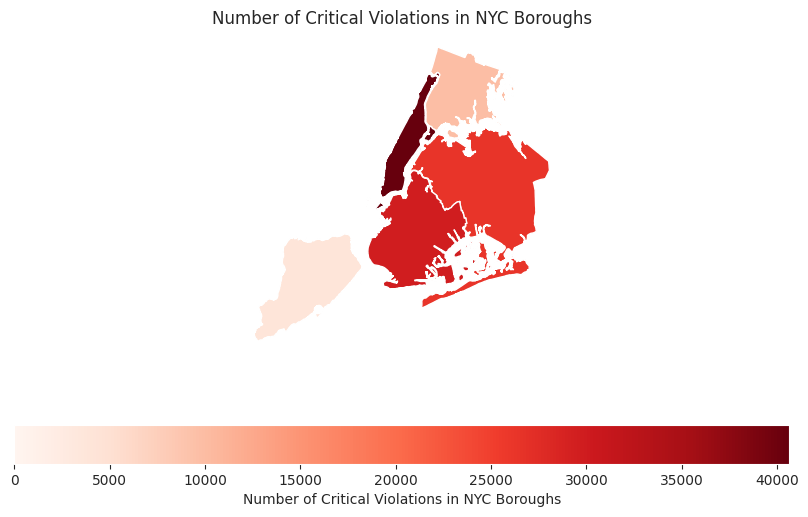

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

df['is_critical'] = df['critical_flag'].apply(lambda x: 1 if x == 'Critical' else 0)

agg_df = df.groupby('boro')['is_critical'].sum().reset_index()

gdf = gpd.read_file('ny.shp')

merged_df = gdf.set_index('boro_name').join(agg_df.set_index('boro'))

norm = mcolors.Normalize(vmin=agg_df['is_critical'].min(), vmax=agg_df['is_critical'].max())

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_df.plot(column='is_critical', ax=ax, legend=True,
            cmap='Reds', norm=norm,
            legend_kwds={'label': "Number of Critical Violations in NYC Boroughs",
                         'orientation': "horizontal"})

ax.set_axis_off()

plt.title('Number of Critical Violations in NYC Boroughs')
plt.show()


# Plotting for analysis of result

### critical by inspection_month/year

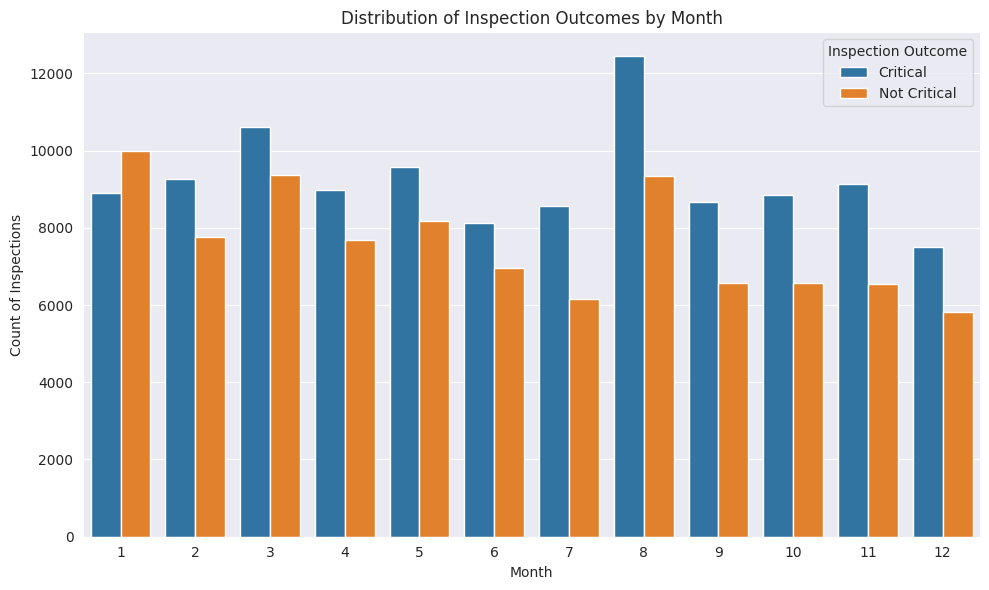

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='inspection_month', hue='critical_flag')
plt.title('Distribution of Inspection Outcomes by Month')
plt.xlabel('Month')
plt.ylabel('Count of Inspections')
plt.legend(title='Inspection Outcome')
plt.tight_layout()
plt.show()

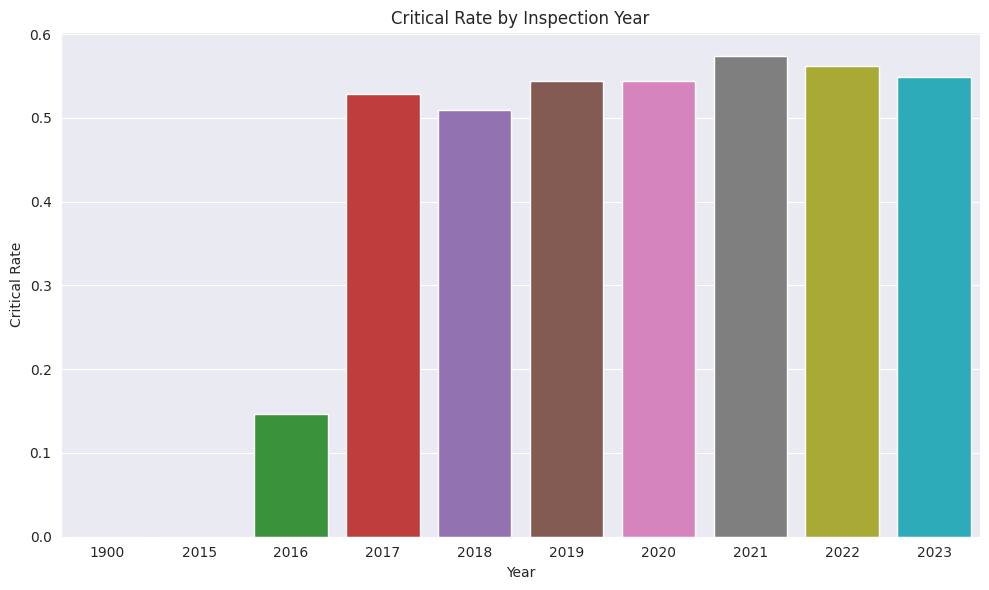

In [ ]:
df['is_critical'] = df['critical_flag'] == 'Critical'

critical_rate_by_year = df.groupby('inspection_year')['is_critical'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=critical_rate_by_year, x='inspection_year', y='is_critical')
plt.title('Critical Rate by Inspection Year')
plt.xlabel('Year')
plt.ylabel('Critical Rate')
plt.tight_layout()
plt.show()

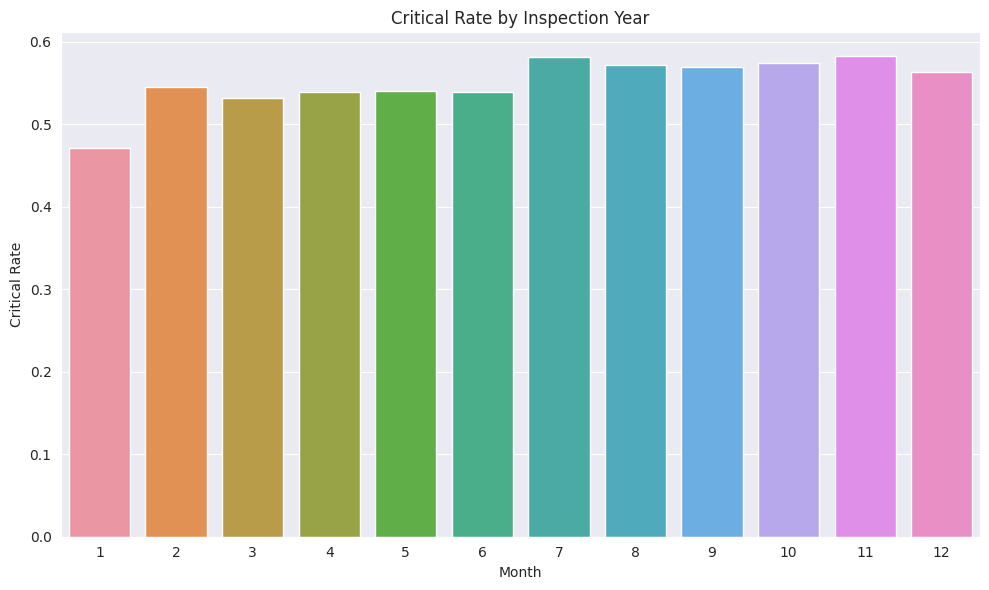

In [ ]:

critical_rate_by_year = df.groupby('inspection_month')['is_critical'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=critical_rate_by_year, x='inspection_month', y='is_critical')
plt.title('Critical Rate by Inspection Year')
plt.xlabel('Month')
plt.ylabel('Critical Rate')
plt.tight_layout()
plt.show()

# Analysis of violation_code_freq

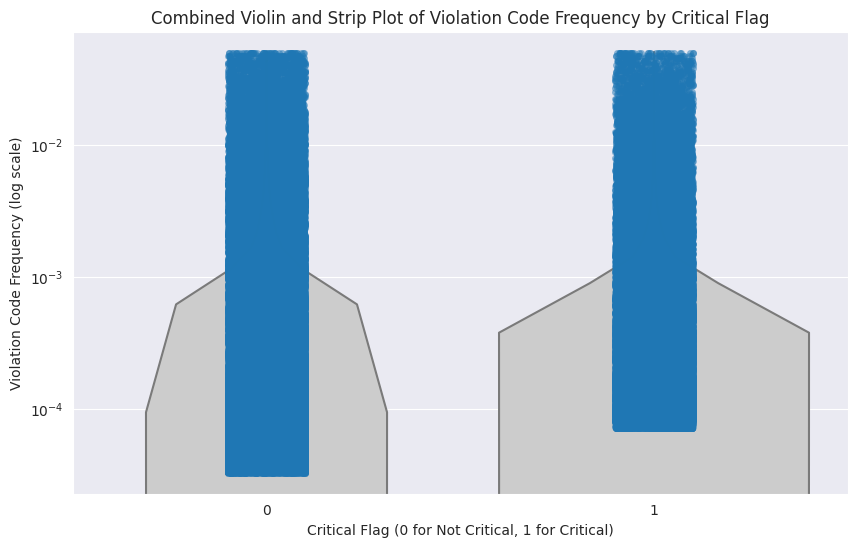

In [ ]:
# convert 'critical_flag' to 0 and 1
df['critical_flag_numeric'] = df['critical_flag'].map({'Not Critical': 0, 'Critical': 1})

plt.figure(figsize=(10, 6))
# Create the violin plot to show the distribution
sns.violinplot(data=df, x='critical_flag_numeric', y='violation_code_freq', inner=None, color=".8")
# Create the strip plot to show individual observations
sns.stripplot(data=df, x='critical_flag_numeric', y='violation_code_freq', jitter=True, alpha=0.5)
plt.yscale('log')  # Apply a logarithmic scale to the y-axis
plt.title("Combined Violin and Strip Plot of Violation Code Frequency by Critical Flag")
plt.xlabel('Critical Flag (0 for Not Critical, 1 for Critical)')
plt.ylabel('Violation Code Frequency (log scale)')
plt.show()


- Strip Plot: We could observe that for critical flag = 0 (Not critical), there are blue dots concentrated on the bottom 1/5 of the plot, but not for critical flag = 1 (Critical). This indicates that a larger proportion of the restaurants that do not have a violation this time has lower violation_code_freq

- Violin Plot: The shape of the violin plot, and the concentration of the strip plot points together suggest that the 'Not Critical' group's violation frequencies are not only generally lower but also less varied. This indicates that the restaurants that had "Critical" violation for this inspection are either having violations that are commonly signaled in the industry, or very rarely seen. This brings to our attention that violation types that are frequently cited across various establishments may be signaling some systemic issues within the industry, or widespread non-compliance with certain regulations. This insight can be alerting and instrumental for regulatory authorities such as the Department of Health and Mental Hygiene (DOHMH), to identify and address common problem areas of this sort, but also an alert for restaurants to be more vigilant about commonly cited health standards.

# Analysis of prev_critical

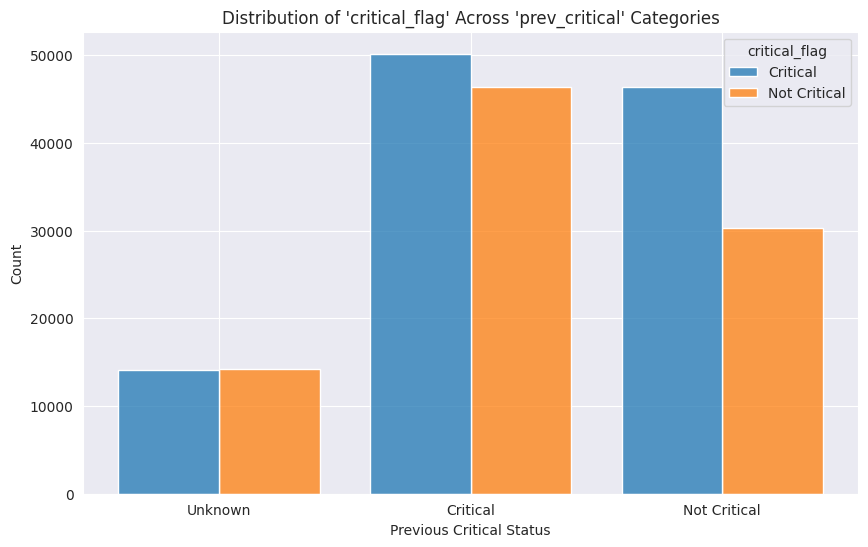

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='prev_critical', hue='critical_flag', multiple='dodge', shrink=0.8)
plt.title("Distribution of 'critical_flag' Across 'prev_critical' Categories")
plt.xlabel('Previous Critical Status')
plt.ylabel('Count')
plt.show()


- This indicates that the restaurants that have had a Critical violation previously would be more tended to not have a critical violation in the next following inspection; whereas the restaurants that did not have a critical violation in the previous closest one inspection is more likely to have a critical violation

# Analysis of critical_to_non_critical_ratio

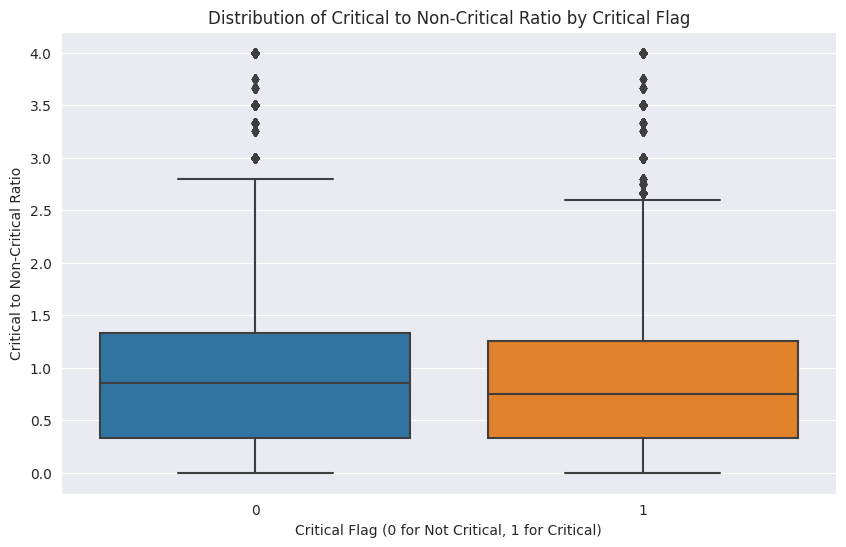

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='critical_flag_numeric', y='critical_to_non_critical_ratio')
plt.title("Distribution of Critical to Non-Critical Ratio by Critical Flag")
plt.xlabel('Critical Flag (0 for Not Critical, 1 for Critical)')
plt.ylabel('Critical to Non-Critical Ratio')
plt.show()

-  median of Not Critical is higher, but there are more outliers for Critical's that have high Critical to Non-Critical Ratio. Thus, the ones with very high past Critical to Non-Critical Ratio tend to remain the behaviour of critical violation
- but the restaurants with moderately-high Critical to Non-Critical Ratio tend to not have a critical violation in the future.